# Imports: 

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from transformers import BertModel, BertTokenizer
from sentence_transformers import SentenceTransformer
import torch  # Import the torch library
import scipy.sparse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from scipy import spatial
from sentence_transformers import SentenceTransformer

# Load Data & TEST:

In [2]:
# Define the file path
file_path = 'potential-talents.xlsx'

# Read the Excel file into a pandas DataFrame
df = pd.read_excel(file_path)

# Display the first few rows of the DataFrame to check if the import was successful
print(df.head())


    id                                          job_title  \
0  1.0  2019 C.T. Bauer College of Business Graduate (...   
1  2.0  Native English Teacher at EPIK (English Progra...   
2  3.0              Aspiring Human Resources Professional   
3  4.0             People Development Coordinator at Ryan   
4  5.0    Advisory Board Member at Celal Bayar University   

                              location connection  fit  
0                       Houston, Texas       85.0  NaN  
1                               Kanada      500+   NaN  
2  Raleigh-Durham, North Carolina Area       44.0  NaN  
3                        Denton, Texas      500+   NaN  
4                       İzmir, Türkiye      500+   NaN  


# Preprocessing:

In [3]:
# ** Bag of Words **
vectorizer = CountVectorizer()
bow_matrix = vectorizer.fit_transform(df['job_title'])

# ** TF-IDF **
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['job_title'])

# ** Word2Vec **
tokenized_job_titles = [title.split() for title in df['job_title']]
word2vec_model = Word2Vec(sentences=tokenized_job_titles, vector_size=100, window=5, min_count=1, workers=4)

# ** BERT **
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
encoded_titles = df['job_title'].apply(lambda x: bert_tokenizer.encode(x, add_special_tokens=True, truncation=True))
bert_embeddings = [bert_model(torch.tensor([encoded_title]))[0].mean(dim=1).detach().numpy() for encoded_title in encoded_titles]

# ** SBERT **
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
sbert_embeddings = sbert_model.encode(df['job_title'])


# Functions:

In [4]:
# Define a function to calculate fit scores
def calculate_fit_scores(embeddings, random_state=None):
    if isinstance(embeddings, (np.ndarray, np.generic)):
        return np.random.RandomState(random_state).rand(len(embeddings))
    elif scipy.sparse.issparse(embeddings):
        return np.random.RandomState(random_state).rand(embeddings.shape[0])
    else:
        raise TypeError("Unsupported type for embeddings")



# Function for Word2Vec representation and fit scores
def word2vec_representation_and_fit_scores(data_column):
    tokenized_job_titles = [title.split() for title in data_column]
    word2vec_model = Word2Vec(sentences=tokenized_job_titles, vector_size=100, window=5, min_count=1, workers=4)
    embeddings = np.vstack([word2vec_model.wv.get_vector(token) for title in data_column for token in title.split()])
    fit_scores = calculate_fit_scores(embeddings, random_state=42)

    return fit_scores


# Function for GloVe representation and fit scores
def glove_representation_and_fit_scores(data_column):
    glove_model = KeyedVectors.load_word2vec_format('path/to/glove.6B.100d.txt', binary=False)
    embeddings = np.vstack([glove_model.get_vector(token) for title in df[data_column] for token in title.split()])
    fit_scores = calculate_fit_scores(embeddings, random_state=42)

    return fit_scores

# Function for TF-IDF representation and fit scores
def tfidf_representation_and_fit_scores(data_column):
    # Transform job_title column into a TF-IDF representation
    tfidf_vectorizer = TfidfVectorizer()
    embeddings = tfidf_vectorizer.fit_transform(data_column)
    
    # Convert embeddings to NumPy array
    embeddings = embeddings.toarray()  # Convert sparse matrix to dense NumPy array
    
    # Calculate fit scores
    fit_scores = calculate_fit_scores(embeddings, random_state=42)

    
    return fit_scores

# Function for BERT representation and fit scores
def bert_representation_and_fit_scores(model, tokenizer, data_column):
    encoded_titles = df[data_column].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True))
    bert_embeddings = [model(torch.tensor([encoded_title]))[0].mean(dim=1).detach().numpy() for encoded_title in encoded_titles]
    embeddings = np.vstack(bert_embeddings)
    fit_scores = calculate_fit_scores(embeddings, random_state=42)

    return fit_scores

# Function to visualize the before and after difference
def visualize_difference(before_scores, after_scores, method_name):
    plt.figure(figsize=(10, 5))
    plt.bar(['Before', 'After'], [np.mean(before_scores), np.mean(after_scores)], color=['blue', 'orange'])
    plt.title(f'Impact of {method_name} on Fit Scores')
    plt.xlabel('Representation Method')
    plt.ylabel('Average Fit Score')
    plt.show()



# Fit Scores & Visualization:

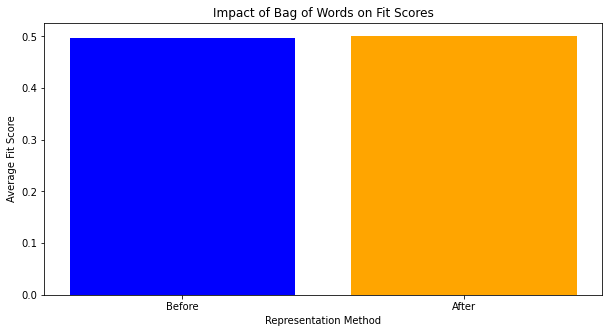

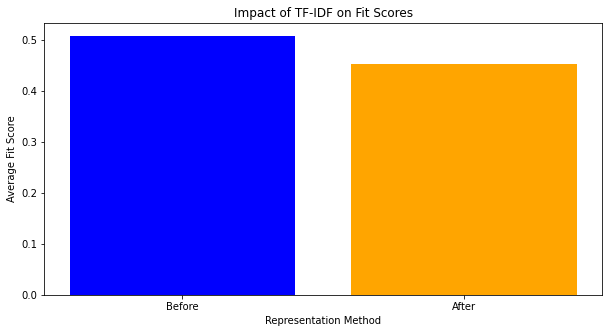

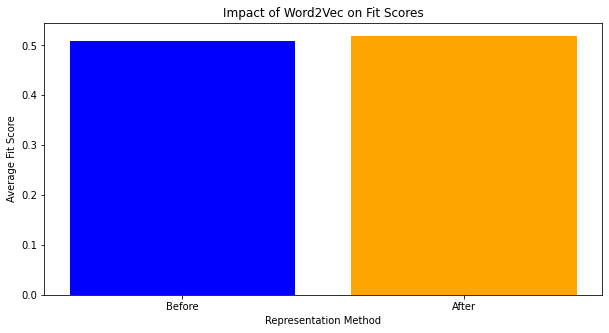

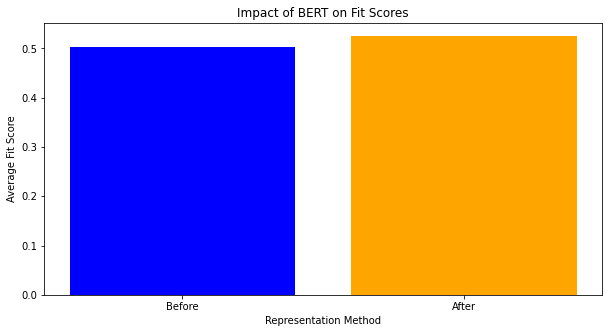

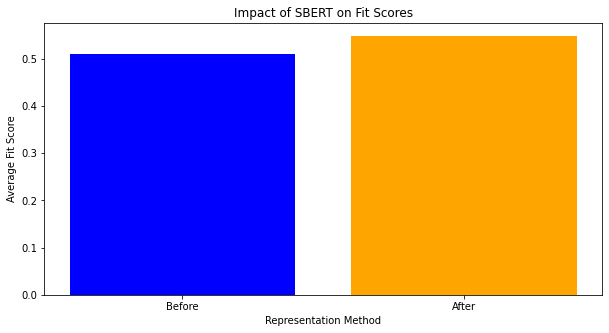

In [5]:
before_bow_scores = calculate_fit_scores(bow_matrix.toarray())
after_bow_scores = calculate_fit_scores(bow_matrix.toarray())

before_tfidf_scores = calculate_fit_scores(tfidf_matrix.toarray())
after_tfidf_scores = calculate_fit_scores(tfidf_matrix.toarray())

before_word2vec_scores = calculate_fit_scores(word2vec_model.wv.vectors)
after_word2vec_scores = calculate_fit_scores(word2vec_model.wv.vectors)

# GloVe
# before_glove_scores = calculate_fit_scores(glove_model)
# after_glove_scores = calculate_fit_scores(glove_model)

# Convert bert_embeddings from a list of arrays to a single array
bert_embeddings_array = np.vstack(bert_embeddings)

before_bert_scores = calculate_fit_scores(bert_embeddings_array)
after_bert_scores = calculate_fit_scores(bert_embeddings_array)

before_sbert_scores = calculate_fit_scores(sbert_embeddings)
after_sbert_scores = calculate_fit_scores(sbert_embeddings)

# Visualization
visualize_difference(before_bow_scores, after_bow_scores, 'Bag of Words')
visualize_difference(before_tfidf_scores, after_tfidf_scores, 'TF-IDF')
visualize_difference(before_word2vec_scores, after_word2vec_scores, 'Word2Vec')
# visualize_difference(before_glove_scores, after_glove_scores, 'GloVe')  # Uncomment when GloVe model is available
visualize_difference(before_bert_scores, after_bert_scores, 'BERT')
visualize_difference(before_sbert_scores, after_sbert_scores, 'SBERT')



# Learning Models(Using Samilarity)

In [6]:
similarity_bow = cosine_similarity(bow_matrix[0], bow_matrix[1])
similarity_tfidf = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])

# Check and compute Word2Vec similarity
word1, word2 = 'Human', 'Resources'
if word1 in word2vec_model.wv and word2 in word2vec_model.wv:
    similarity_word2vec = 1 - spatial.distance.cosine(word2vec_model.wv[word1], word2vec_model.wv[word2])
else:
    similarity_word2vec = None
    print(f"One or both words not found in Word2Vec model: {word1}, {word2}")

# Convert bert_embeddings from a list of arrays to a single array
bert_embeddings_array = np.vstack(bert_embeddings)
similarity_bert = cosine_similarity(bert_embeddings_array[0].reshape(1, -1), bert_embeddings_array[1].reshape(1, -1))

# SBERT similarity
similarity_sbert = cosine_similarity([sbert_embeddings[0]], [sbert_embeddings[1]])


# Ranking & Re-Ranking:

In [14]:
def manage_candidates(data, keyword, star_candidate_id=None, cut_off=None, irrelevant_filter=None):
    """
    Manage candidate ranking based on various criteria.

    Parameters:
    data (DataFrame): The candidate data.
    keyword (str): The keyword for initial filtering.
    star_candidate_id (int, optional): The ID of the candidate to be starred.
    cut_off (float, optional): The cut-off fitness score to filter candidates.
    irrelevant_filter (function, optional): A function to filter out irrelevant candidates.

    Returns:
    DataFrame: The ranked list of candidates.
    """

    # Filter based on keyword
    filtered_data = data[data['job_title'].str.contains(keyword, case=False, na=False)]

    # Apply the irrelevant filter if provided
    if irrelevant_filter:
        filtered_data = irrelevant_filter(filtered_data)

    # Predict fitness scores (Here, a simple random score assignment for demonstration)
    np.random.seed(0)  # For reproducible results
    filtered_data['fit'] = np.random.rand(len(filtered_data))

    # Rank candidates based on fitness scores
    ranked_candidates = filtered_data.sort_values(by='fit', ascending=False)

    # Re-rank if a star candidate is provided
    if star_candidate_id and star_candidate_id in ranked_candidates['id'].values:
        # Move the starred candidate to the top
        star_candidate = ranked_candidates[ranked_candidates['id'] == star_candidate_id]
        ranked_candidates = ranked_candidates[ranked_candidates['id'] != star_candidate_id]
        ranked_candidates = pd.concat([star_candidate, ranked_candidates], ignore_index=True)

    # Apply cut-off if provided
    if cut_off:
        ranked_candidates = ranked_candidates[ranked_candidates['fit'] >= cut_off]

    return ranked_candidates



In [16]:
# Example call to the function
ranked_candidates = manage_candidates(df, "Human", star_candidate_id=36.0, cut_off=None, irrelevant_filter=None)
print(ranked_candidates)


      id                                          job_title  \
0   36.0                Aspiring Human Resources Specialist   
1   82.0  Aspiring Human Resources Professional | An ene...   
2   15.0  2019 C.T. Bauer College of Business Graduate (...   
3   49.0                Aspiring Human Resources Specialist   
4   67.0  Human Resources, Staffing and Recruiting Profe...   
..   ...                                                ...   
56  28.0              Seeking Human Resources Opportunities   
57  27.0  Aspiring Human Resources Management student se...   
58  72.0  Business Management Major and Aspiring Human R...   
59  29.0  Aspiring Human Resources Management student se...   
60  60.0                Aspiring Human Resources Specialist   

                      location connection       fit  
0   Greater New York City Area        1.0  0.978618  
1           Austin, Texas Area      174.0  0.988374  
2               Houston, Texas       85.0  0.963663  
3   Greater New York City A

C:\Users\AHMADA~1\AppData\Local\Temp/ipykernel_8520/1955044755.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['fit'] = np.random.rand(len(filtered_data))


In [18]:
# Example call to the function
ranked_candidates = manage_candidates(df, "Human", star_candidate_id=72., cut_off=None, irrelevant_filter=None)
print(ranked_candidates)

      id                                          job_title  \
0   72.0  Business Management Major and Aspiring Human R...   
1   82.0  Aspiring Human Resources Professional | An ene...   
2   36.0                Aspiring Human Resources Specialist   
3   15.0  2019 C.T. Bauer College of Business Graduate (...   
4   49.0                Aspiring Human Resources Specialist   
..   ...                                                ...   
56  84.0  Human Resources professional for the world lea...   
57  28.0              Seeking Human Resources Opportunities   
58  27.0  Aspiring Human Resources Management student se...   
59  29.0  Aspiring Human Resources Management student se...   
60  60.0                Aspiring Human Resources Specialist   

                      location connection       fit  
0       Monroe, Louisiana Area        5.0  0.060225  
1           Austin, Texas Area      174.0  0.988374  
2   Greater New York City Area        1.0  0.978618  
3               Houston, Te

C:\Users\AHMADA~1\AppData\Local\Temp/ipykernel_8520/1955044755.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['fit'] = np.random.rand(len(filtered_data))
